### Описание задачи
------
Во вложении датасет, который мы собрали из первичных полученных нами данных для работы лаборатории. 

* Столбец Index - это потребитель: каждая строчка относится к одному определенному потребителю, в ней указывается его потребление по дням начиная со столбца val_1 до столбца val_731. 

* Каждый столбец val_1 : val_731 означает день, значение в ячейке - дневное потребление данным потребителем в этот день, то есть таблица содержит в себе данные за 2 года (365 х 2 = 730).

У некоторых потребителей вначале идет большое количество Nan - это означает что в тот период времени данный потребитель просто не существовал - данные по нему появляются позже и далее идут регулярно. 

Столбец val_0 - это категория потребителей (квартира, больница, завод) всего 12 категорий. Естественно у каждого типа потребителей свой характер потребления. 

---------


### Наши задачи:

1. Выявить нехарактерное для данного потребителя потребление в определенный день. 

Если поступающие за день данные нейросеть сочтет нехарактерными для сложившегося у данного потребителя паттерна потребления (возможные причины - техническая неисправность счетчика, сбой передачи данных, воровство), то она должна сигнализировать об этом. 

2. Предсказать будущее значение потребления по конкретному потребителю.

In [1]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import os

In [2]:
os.chdir('/content/drive/My Drive/_Проекты/Счетчики')

# 1. Выявление аномалий в потреблении
-----
* Задача попроще: аномалией считаем, если потребление выходит за рамки (2std) группы. Большой недостаток такого подхода в том, что даже внутри группы потребление сильно отличется!

* Поэтому мы рекомендуем не обращать внимание на группу и обучать сетку на каждом конкретном потребителе. А для оценки отклонений просто ежедневно всех перебирать

### Готовим данные

In [ ]:
from IPython.display import clear_output

In [3]:
# скачали и посмотрели на выборку
df = pd.read_csv('water_consumption.csv', sep=";", index_col='index')
df.rename(columns = {'vals_0': 'Group'}, inplace=True)
print(df.shape)
df[260:265]

(6518, 732)


,Group,vals_1,vals_2,vals_3,vals_4,vals_5,vals_6,vals_7,vals_8,vals_9,vals_10,vals_11,vals_12,vals_13,vals_14,vals_15,vals_16,vals_17,vals_18,vals_19,vals_20,vals_21,vals_22,vals_23,vals_24,vals_25,vals_26,vals_27,vals_28,vals_29,vals_30,vals_31,vals_32,vals_33,vals_34,vals_35,vals_36,vals_37,vals_38,vals_39,...,vals_692,vals_693,vals_694,vals_695,vals_696,vals_697,vals_698,vals_699,vals_700,vals_701,vals_702,vals_703,vals_704,vals_705,vals_706,vals_707,vals_708,vals_709,vals_710,vals_711,vals_712,vals_713,vals_714,vals_715,vals_716,vals_717,vals_718,vals_719,vals_720,vals_721,vals_722,vals_723,vals_724,vals_725,vals_726,vals_727,vals_728,vals_729,vals_730,vals_731
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
260,1,12.44,11.12,9.23,11.81,8.99,11.02,10.50,11.27,10.60,12.58,10.94,9.73,11.68,11.13,12.86,12.50,9.38,9.52,10.57,11.34,10.65,11.07,10.75,13.12,12.69,9.71,10.98,9.40,8.57,11.95,13.25,10.39,11.03,9.34,9.63,12.06,12.46,13.33,14.03,...,10.96,10.11,10.18,10.26,10.52,10.48,12.49,11.97,11.30,10.40,9.32,10.23,12.27,12.61,12.16,11.89,12.33,12.12,11.17,10.98,10.52,10.89,11.330000,11.900000,15.570000,11.310000,10.220000,9.93,10.57,8.42,9.11,10.99,10.91,8.96,10.29,12.85,11.25,12.31,10.94,12.32
261,1,23.45,27.76,28.29,29.67,28.00,26.12,27.91,31.37,29.09,29.79,29.43,27.43,29.64,28.76,26.05,27.66,36.09,25.63,26.00,25.51,27.37,27.67,26.92,30.61,27.35,25.48,23.72,25.99,24.65,30.37,31.39,27.00,26.07,26.22,26.92,27.62,29.26,32.40,29.82,...,17.11,15.69,17.57,16.57,16.83,17.99,17.94,17.43,18.30,16.52,17.56,18.73,19.20,16.48,18.06,17.41,16.22,17.42,18.97,17.50,14.43,17.37,17.620000,18.350000,19.500000,17.950000,16.720000,16.07,19.02,22.64,20.28,20.09,15.64,17.95,16.09,16.05,16.63,18.23,17.75,20.10
262,1,21.06,21.55,23.09,25.42,23.48,25.23,24.41,21.68,27.02,27.19,23.02,24.51,22.86,21.50,23.00,25.72,23.91,24.24,25.56,24.40,23.47,21.48,22.99,23.31,22.83,22.55,26.07,22.60,22.41,24.02,28.17,23.88,24.64,20.80,22.47,22.37,21.63,23.32,23.00,...,17.93,20.80,19.28,22.56,19.79,21.90,20.07,17.81,19.82,21.34,19.67,20.47,19.69,20.53,22.72,20.87,23.86,22.04,21.99,23.46,19.33,18.22,19.420000,20.950000,21.100000,18.900000,18.120000,20.05,18.54,19.66,20.88,16.77,16.21,18.56,18.68,17.18,18.14,16.37,17.67,22.06
263,1,39.34,39.53,40.99,47.21,42.86,42.76,44.18,46.12,48.14,49.04,48.47,46.31,43.34,42.39,47.85,42.19,49.37,41.32,42.64,42.25,32.34,47.30,49.22,49.88,45.16,42.22,38.94,38.90,37.85,45.26,47.27,41.52,41.17,40.09,42.42,45.72,43.26,48.09,42.01,...,26.18,29.43,27.53,25.55,28.68,30.76,27.84,25.45,29.52,27.42,33.90,34.69,32.65,33.41,32.69,33.18,30.83,26.99,32.47,37.30,44.39,28.81,29.290000,27.230000,26.620000,29.760000,31.900000,31.13,29.98,32.96,30.12,30.51,34.74,31.99,34.44,30.41,33.10,33.13,31.55,36.65
264,1,17.17,16.50,17.67,19.66,16.01,18.13,16.43,19.61,22.28,23.04,21.94,20.44,18.39,19.54,21.28,26.06,25.11,27.90,21.40,21.32,22.62,27.60,20.20,24.97,19.02,16.81,19.34,20.00,17.62,20.07,20.87,21.43,19.52,19.75,20.49,27.89,24.21,26.13,23.50,...,13.97,12.45,12.02,12.14,15.68,13.08,13.53,11.71,12.22,14.47,14.36,16.01,14.63,14.13,16.00,13.21,13.65,14.43,15.35,14.15,13.90,12.03,14.148393,13.652257,13.652256,13.455693,13.018875,12.58,13.17,14.51,13.68,21.08,25.50,17.43,14.37,12.88,12.17,12.55,14.62,15.31


In [4]:
# сгруппировали по типам потребителей и изучили характерисики группы
dfGroup = df.groupby('Group')
dfGroup['vals_731'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
1,4258.0,35.477590,41.947388,-0.59,12.9625,24.190,45.127500,672.770000
2,292.0,0.912105,7.181416,-2.00,0.0000,0.065,0.833015,122.000000
3,298.0,3.031651,15.005605,-1.00,0.0000,0.270,1.000000,207.457419
4,78.0,67.976258,237.546061,0.00,0.0000,3.345,18.552500,1567.790000
5,25.0,2.917333,4.226393,0.00,0.0000,0.850,5.150000,17.770000
6,259.0,9.470503,25.455267,0.00,0.0000,1.000,4.260000,192.000000
7,16.0,29.873125,47.317920,0.00,0.0000,1.940,38.747500,160.060000
8,81.0,4.045797,9.229248,0.00,0.0000,0.380,3.090000,53.250000
9,13.0,0.330000,0.301109,0.00,0.0700,0.310,0.410000,1.030000


Видим, что Группы сильно отличаются одна от другой.

Поэтому лучшим решением будет создание сети и выявление отклонений индивидуально по каждой группе.

## Выявление аномалий с помощью математики - проверка НС
----
тот случай, когда можно без нейронок :)


In [5]:
# скачали и посмотрели на выборку
os.chdir('/content/drive/My Drive/_Проекты/Счетчики')
df = pd.read_csv('dataset_to_send.csv', sep=";", index_col='index')
del df['vals_0']
print(df.shape)
df[-3:]

(6518, 731)


,vals_1,vals_2,vals_3,vals_4,vals_5,vals_6,vals_7,vals_8,vals_9,vals_10,vals_11,vals_12,vals_13,vals_14,vals_15,vals_16,vals_17,vals_18,vals_19,vals_20,vals_21,vals_22,vals_23,vals_24,vals_25,vals_26,vals_27,vals_28,vals_29,vals_30,vals_31,vals_32,vals_33,vals_34,vals_35,vals_36,vals_37,vals_38,vals_39,vals_40,...,vals_692,vals_693,vals_694,vals_695,vals_696,vals_697,vals_698,vals_699,vals_700,vals_701,vals_702,vals_703,vals_704,vals_705,vals_706,vals_707,vals_708,vals_709,vals_710,vals_711,vals_712,vals_713,vals_714,vals_715,vals_716,vals_717,vals_718,vals_719,vals_720,vals_721,vals_722,vals_723,vals_724,vals_725,vals_726,vals_727,vals_728,vals_729,vals_730,vals_731
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6515,19.67742,19.677419,19.677419,19.67742,19.67742,19.677421,19.677418,19.838712,19.838707,19.838711,19.838711,19.838709,19.838711,19.838708,19.838711,19.83871,19.838711,19.838709,19.838708,19.83871,19.838709,19.838711,19.838712,19.838711,19.838709,19.83871,19.838711,19.838713,19.838709,19.838709,19.838709,19.83871,19.838709,19.838708,19.83871,19.83871,19.838709,27.900001,27.899999,27.9,...,24.000000,24.000000,22.000000,22.00,25.0,25.00,23.00,26.00,25.00,26.00,24.00,25.00,22.00,24.00,24.00,24.00,24.00,23.00,24.00,30.00,23.00,21.0,19.00,21.00,18.00,19.00,20.00,18.00,19.0,19.00,19.00,16.00,21.00,22.00,28.00,29.00,28.00,23.00,26.00,28.00
6516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,307.233332,349.233332,348.502635,347.00,357.0,348.00,341.00,338.00,345.00,321.00,352.00,359.00,349.00,353.00,362.00,340.00,352.00,353.00,379.00,369.00,351.00,349.0,346.00,336.00,339.00,364.00,357.00,347.00,342.0,356.00,340.00,340.00,376.00,358.00,351.00,347.00,353.00,340.00,337.00,379.00
6517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.170000,4.220000,6.150000,3.22,4.5,5.26,6.22,6.24,5.28,7.28,2.25,5.37,5.21,7.26,7.26,7.24,7.22,4.27,5.29,5.25,6.31,7.3,6.29,7.24,3.28,5.32,6.23,5.26,7.2,6.22,7.25,5.27,5.33,7.21,6.28,6.26,7.27,7.23,4.38,6.33


Некоторые потребители не потребляют )))

Поэтому мы их удалим из анализа

In [6]:
#Удаляем потребителей с потреблением = 0
df = df.drop(np.where(df == 0)[0])
print('До транспонирования: ', df.shape)
df = df.T # Транспонируем данные
print('После транспонирования: ', df.shape)
df[-3:]

До транспонирования:  (2562, 731)
После транспонирования:  (731, 2562)


index,6,12,14,16,44,49,52,54,56,58,62,64,66,67,70,72,74,75,76,77,80,81,82,83,84,87,89,96,97,105,107,108,110,115,129,132,133,134,135,136,...,6442,6444,6446,6447,6449,6451,6453,6454,6455,6457,6458,6459,6461,6464,6467,6470,6472,6473,6474,6478,6480,6482,6483,6484,6485,6488,6490,6491,6493,6495,6496,6497,6498,6501,6503,6505,6506,6509,6510,6515
vals_729,0.89,7.40194,11.000000,14.74,2.72,6.04,0.43,3.58,3.62,0.02,1.40,10.01,3.0,61.94,19.12,37.75,108.26,67.38,53.84,77.36,23.71,106.16,30.47,171.582370,20.28,81.05,124.87,24.87,52.95,0.752258,8.64,7.69,1.22,11.41,2.20,39.90,61.57,65.12,38.97,83.40,...,69.90,2.10,0.19,0.08,0.26,90.0,2.67,92.72,1.50,5.44,1.07,83.54,169.0,27.51,0.41,31.365030,22.712094,15.28,24.67,30.55,20.64,37.03,272.136817,70.1,68.5,0.90,0.82,7.224516,94.48,2.24,15.17,18.95,30.30,170.22,24.28,0.65,2.16,8.75,86.97,23.0
vals_730,1.51,7.42000,7.873656,14.18,1.84,1.25,0.46,0.13,0.09,0.02,1.15,11.10,3.0,62.73,21.21,34.57,104.20,65.80,52.83,77.58,23.47,94.86,21.07,165.875583,18.58,81.14,125.81,11.95,50.07,0.752256,7.28,7.08,0.61,12.12,0.40,42.03,61.62,67.55,37.34,75.98,...,67.82,4.36,0.09,0.07,0.28,81.0,2.91,95.75,0.94,6.28,0.30,86.21,184.0,26.70,0.36,28.621518,23.612099,15.72,28.15,28.66,21.27,35.74,279.918957,69.3,95.8,0.15,0.64,10.924518,103.49,1.00,8.84,16.62,25.99,201.88,10.92,0.52,1.70,9.35,87.76,26.0
vals_731,2.08,7.10000,5.000000,19.40,1.89,1.19,0.26,0.14,0.41,0.03,0.85,11.35,2.0,69.14,23.87,39.51,123.75,81.22,57.95,94.07,28.31,110.42,24.14,175.785333,23.34,89.51,141.24,10.65,52.46,0.752256,7.25,6.74,0.33,13.56,0.16,46.32,68.26,71.38,41.25,89.99,...,76.99,2.87,0.12,0.13,0.26,99.0,0.91,107.68,1.05,4.87,0.50,98.22,195.0,32.81,0.39,28.813845,28.042092,17.70,32.99,36.12,24.61,43.00,314.865360,76.9,108.0,0.12,0.59,6.064518,112.54,0.99,10.29,17.27,35.41,209.00,1.28,0.43,1.69,9.37,109.34,28.0


In [7]:
dailyChange = df.pct_change() # посчитали изменение дневного потребления (которые будем анализировать)
dailyChange.replace([np.inf, -np.inf], np.nan, inplace=True) # замена inf на NaN
# используем метод .transform(), чтобы заполнить значения NaN групповым средним
dailyChange = dailyChange.transform(lambda x: x.fillna(x.mean()))
dailyChange.fillna(0, inplace=True) # Заменили NA значения на 0

print(dailyChange.shape)
dailyChange[-3:]

(731, 2562)


index,6,12,14,16,44,49,52,54,56,58,62,64,66,67,70,72,74,75,76,77,80,81,82,83,84,87,89,96,97,105,107,108,110,115,129,132,133,134,135,136,...,6442,6444,6446,6447,6449,6451,6453,6454,6455,6457,6458,6459,6461,6464,6467,6470,6472,6473,6474,6478,6480,6482,6483,6484,6485,6488,6490,6491,6493,6495,6496,6497,6498,6501,6503,6505,6506,6509,6510,6515
vals_729,-0.258333,-0.037257,-0.153846,-0.186085,-0.347722,-0.053292,-0.245614,-0.084399,-0.121359,-0.857143,0.147541,-0.096570,0.500000,0.019253,-0.106959,-0.032299,0.000740,-0.025315,-0.048427,-0.013265,-0.016591,0.022933,0.281868,-0.099069,-0.014098,-0.023023,-0.057727,0.343598,0.024773,0.000000,0.017668,-0.007742,-0.031746,0.177503,0.037736,-0.135615,-0.099327,-0.098560,0.026337,0.014228,...,-0.052075,-0.192308,-0.366667,-0.111111,0.000000,0.058824,0.628049,-0.045992,-0.222798,0.172414,-0.009259,-0.007249,-0.028736,0.028027,-0.145833,0.035568,-0.095211,0.035932,0.145843,-0.027380,-0.127642,-0.255529,-0.095561,0.040059,0.036309,-0.126214,0.223881,0.171952,0.075347,0.204301,-0.162804,0.140879,-0.141643,0.064873,-0.033055,-0.071429,0.004651,0.148294,0.013164,-0.178571
vals_730,0.696629,0.002440,-0.284213,-0.037992,-0.323529,-0.793046,0.069767,-0.963687,-0.975138,0.000000,-0.178571,0.108891,0.000000,0.012754,0.109310,-0.084238,-0.037502,-0.023449,-0.018759,0.002844,-0.010122,-0.106443,-0.308500,-0.033260,-0.083826,0.001110,0.007528,-0.519501,-0.054391,-0.000003,-0.157407,-0.079324,-0.500000,0.062226,-0.818182,0.053383,0.000812,0.037316,-0.041827,-0.088969,...,-0.029757,1.076190,-0.526316,-0.125000,0.076923,-0.100000,0.089888,0.032679,-0.373333,0.154412,-0.719626,0.031961,0.088757,-0.029444,-0.121951,-0.087470,0.039627,0.028796,0.141062,-0.061866,0.030523,-0.034837,0.028596,-0.011412,0.398540,-0.833333,-0.219512,0.512145,0.095364,-0.553571,-0.417271,-0.122955,-0.142244,0.185995,-0.550247,-0.200000,-0.212963,0.068571,0.009084,0.130435
vals_731,0.377483,-0.043127,-0.364971,0.368124,0.027174,-0.048000,-0.434783,0.076923,3.555556,0.500000,-0.260870,0.022523,-0.333333,0.102184,0.125413,0.142898,0.187620,0.234347,0.096915,0.212555,0.206221,0.164031,0.145705,0.059742,0.256189,0.103155,0.122645,-0.108787,0.047733,0.000000,-0.004121,-0.048023,-0.459016,0.118812,-0.600000,0.102070,0.107757,0.056699,0.104713,0.184391,...,0.135211,-0.341743,0.333333,0.857143,-0.071429,0.222222,-0.687285,0.124595,0.117021,-0.224522,0.666667,0.139311,0.059783,0.228839,0.083333,0.006720,0.187615,0.125954,0.171936,0.260293,0.157029,0.203134,0.124845,0.109668,0.127349,-0.200000,-0.078125,-0.444871,0.087448,-0.010000,0.164027,0.039110,0.362447,0.035268,-0.882784,-0.173077,-0.005882,0.002139,0.245898,0.076923


In [8]:
firmNames = list(dailyChange) # Получаем имена столбцов (потребителей)

In [9]:
dailyChange_stat = dailyChange.describe() # получим статистику по каждому потребителю
dailyChange_stat # выведем статистики по потребителям

index,6,12,14,16,44,49,52,54,56,58,62,64,66,67,70,72,74,75,76,77,80,81,82,83,84,87,89,96,97,105,107,108,110,115,129,132,133,134,135,136,...,6442,6444,6446,6447,6449,6451,6453,6454,6455,6457,6458,6459,6461,6464,6467,6470,6472,6473,6474,6478,6480,6482,6483,6484,6485,6488,6490,6491,6493,6495,6496,6497,6498,6501,6503,6505,6506,6509,6510,6515
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,7.310000e+02,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,7.310000e+02,7.310000e+02,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.174989,0.073901,0.226555,0.055266,0.105306,0.462094,2.491401,3.420265,7.667270,1.107598,0.125954,0.034136,0.056432,0.005380,0.047327,0.048133,0.005840,0.003308,0.002680,0.004853,0.005320,0.004022,0.007878,0.006236,0.007107,0.003566,0.014352,1.405273,0.003487,0.042161,0.001551,0.049775,0.261499,0.006230,2.603438,0.006658,0.001899,0.002515,0.003373,0.003070,...,0.002572,0.132527,0.967429,0.383684,0.113636,0.004239,0.109130,0.003711,0.144031,0.018859,0.018923,1.308276e-02,0.003866,0.046229,0.122744,0.006881,0.003919,0.003543,0.007478,4.615070,0.009482,0.008714,-3.130337,4.757562e-03,4.894052e+01,0.508154,0.024334,0.024331,0.005013,0.137128,0.026650,-1.147353,0.008001,0.004444,0.732797,0.095443,0.059476,0.006970,0.003812,0.006284
std,0.731700,0.709417,0.888638,0.394772,0.278059,1.455203,5.242455,7.914661,22.254244,1.948766,0.596641,0.280010,0.298785,0.102843,0.918476,0.524735,0.105817,0.075929,0.070346,0.100360,0.102937,0.087574,0.125348,0.137075,0.117080,0.098568,0.354077,6.939865,0.080837,0.386041,0.055164,0.273965,1.185707,0.111183,4.747006,0.155662,0.070275,0.070041,0.080607,0.082852,...,0.045252,0.643183,3.846336,2.243910,1.002975,0.089144,1.047104,0.083087,0.700431,0.162607,0.215890,2.645796e-01,0.086665,0.393707,0.849957,0.123027,0.061936,0.095559,0.125132,124.606925,0.146797,0.168492,84.591443,9.547691e-02,1.321208e+03,1.771947,0.229919,0.252926,0.093167,0.763664,0.189980,18.641076,0.095119,0.080144,1.715387,0.575710,0.501184,0.128326,0.080714,0.109280
min,-0.861644,-0.917663,-0.877551,-0.851459,-0.734219,-0.844371,-0.985494,-0.990602,-0.995238,-0.990617,-0.940966,-0.806748,-0.700000,-0.615262,-0.958462,-0.230298,-0.628085,-0.282625,-0.300335,-0.582855,-0.319611,-0.545179,-0.395343,-0.843739,-0.513005,-0.484157,-0.921132,-0.982751,-0.328581,-0.916905,-0.346620,-0.383582,-0.836478,-0.319277,-0.951613,-0.884803,-0.344117,-0.342467,-0.323867,-0.318530,...,-0.319235,-0.857807,-0.988372,-0.977778,-0.909091,-0.320312,-0.970149,-0.286459,-0.866873,-0.558824,-0.719626,-8.606743e-01,-0.383966,-0.879032,-0.964617,-0.461574,-0.268311,-0.535044,-0.543473,-0.820212,-0.693972,-0.751376,-2287.097943,-3.560372e-01,-8.822263e-01,-0.916201,-0.642857,-0.925973,-0.343587,-0.835616,-0.749294,-504.187303,-0.458314,-0.293408,-0.883405,-0.844221,-0.956863,-0.600083,-0.305759,-0.432432
25%,-0.274078,-0.124735,-0.333333,-0.140616,0.105306,0.388622,0.658333,1.653333,2.339583,1.107598,-0.210853,-0.129404,0.000000,-0.044371,-0.054450,0.016378,-0.037208,-0.037928,-0.041990,-0.043628,-0.066816,-0.036678,-0.077264,-0.036077,-0.064940,-0.038361,-0.032528,-0.404295,-0.042590,-0.137255,0.001551,0.049775,-0.295428,-0.067907,0.022353,-0.051431,-0.038962,-0.041765,-0.047918,-0.037595,...,0.002572,-0.164937,-0.400000,-0.307692,-0.071429,-0.04

------------------------------ 
Дни аномального потребления Consume # 12 :
 ------------------------------ 

1 	 vals_34 	 8.586805555555555
2 	 vals_288 	 1.5014044943820224
3 	 vals_404 	 6.792243767313019
4 	 vals_432 	 13.207261724659606
5 	 vals_561 	 3.310846560846562


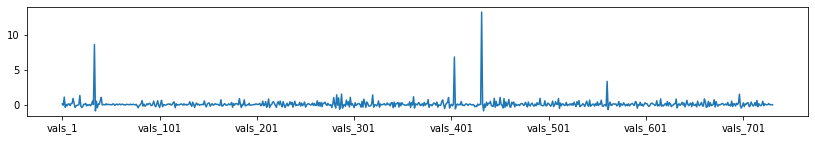

In [51]:
#for n in firmNames: # если нужно пройтись по всему списку клиентов
  #clear_output()
x = 0
number = 1 # выбрали порядковый номер потребителя
for n in [firmNames[number]]: # если будет ошибка, значит такого потребителя просто нет
  dailyChange_max = dailyChange_stat[n]['mean'] + 2*dailyChange_stat[n]['std']
  dailyChange_min = dailyChange_stat[n]['mean'] - 2*dailyChange_stat[n]['std']
  dailyChange_min, dailyChange_max

  idx = dailyChange[n].index.tolist() # получаем список индексов
  print('-'*30, '\nДни аномального потребления Consume #', n, ':\n', '-'*30, '\n')
  j = -1
  dailyChange[n].plot(figsize=(14, 2)) #строим график чтобы визуально оценить выбросы
  for i in dailyChange[n]:
    j += 1
    if i > dailyChange_max  or i < dailyChange_min: 
      x += 1 # счетчик числа frauds
      print(x, '\t', idx[j], '\t', i)

## Обучение Нейросети
в будущем для каждого потребителя будут храниться индивидуальные модели, которые будут загружаться при необходимости

### Импорт и функции:
* get_consumer
* Autoencoder
* model_fit
* get_mistakes


In [11]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, LSTM, RepeatVector
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
RANDOM_SEED = 42 # задаем случайное значение

In [13]:
def get_consumer(dailyChange, number):
  consumer = dailyChange[firmNames[number]]
  #group9['class'] = 0 # добавили столбец для расчета выбросов
  consumer.plot(figsize=(14, 2)) #строим график чтобы визуально оценить выбросы

  #берем характеристики группы и сравниваем их 
  consumer_stat = consumer.describe()
  consumer_norma = consumer_stat['mean'] + 2*consumer_stat['std']
  consumer_norma_max = consumer_stat['mean'] + 2*consumer_stat['std']
  consumer_norma_min = consumer_stat['mean'] - 2*consumer_stat['std']
  #print('\nConsumer name = ', firmNames[number])
  print('consumer_mean = ', round(consumer_stat['mean'], 3),
        '\tconsumer_2std = ', round(2*consumer_stat['std'], 3),
        '\tconsumer_norma ', round(consumer_norma_min, 3), '==>', round(consumer_norma_max, 3))

  
  # Выделим отклонения
  frauds = consumer[(consumer < consumer_norma_min) | (consumer > consumer_norma_max)]
  # Выделим норму
  normal = consumer[(consumer >= consumer_norma_min) & (consumer <= consumer_norma_max)]

  #print('frauds cases = ', len(frauds), '\tnormal cases = ', len(normal))

  # Нормализуем данные
  normal = MinMaxScaler().fit_transform(normal.values.reshape(-1, 1))
  frauds = MinMaxScaler().fit_transform(frauds.values.reshape(-1, 1))

  # берём нормализованные данные и разбиваем на train_test(только 'X')
  X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)
  #print('X_train = ', X_train.shape, '\tX_test = ', X_test.shape, '\tfrauds = ', frauds.shape)

  return X_train, X_test, normal, frauds

In [14]:
def Autoencoder(X_train): # объявляем автокодировщик для определения мошенич.транзакций
  dataInput = Input(shape=(X_train.shape[1], )) # задаем эти размеры как входные в сеть
  
  x = Dense(100, activation='linear')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(X_train.shape[1], activation='linear')(x) # и через полносвязный слой размером X_train.shape[1]
  
  autoencoder = Model(inputs = dataInput, outputs=x) # собрали модель 
  autoencoder.compile(optimizer = Adam(learning_rate = 1e-03), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [15]:
def model_fit(X_train, firmNames, number):
  os.chdir('/content/drive/My Drive/_Проекты/Счетчики/data')
  model = Autoencoder(X_train)

  # коллбэки
  early_stopping = EarlyStopping(monitor = 'loss',patience = 8, verbose = 0,
                                 restore_best_weights = True)
  reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.9, patience = 2, 
                                min_lr = 1e-07, verbose = 0)
  checkpoint = ModelCheckpoint('consumer_%d.h5' % (firmNames[number]), monitor='loss',
                               verbose = 0, save_best_only=True, save_weights_only = True)
  

  history = model.fit(X_train, X_train, epochs = 100, verbose = 0,
                      callbacks = [early_stopping, reduce_lr, checkpoint],
                      batch_size=1) # загружаем данные в модель(X_train'ы) и обучаем)

  #clear_output()

  title = 'Consume #%d' % (firmNames[number])
  plt.figure()
  plt.plot(history.history['loss'])
  plt.title(title)
  plt.grid()
  plt.show()

In [16]:
def get_mistakes(X_test, frauds, firmNames, number):
  os.chdir('/content/drive/My Drive/_Проекты/Счетчики/data')
  model = Autoencoder(X_train)
  model.load_weights('consumer_%d.h5' % (firmNames[number]))

  predictions_normal = model.predict(X_test) # делаем предсказание по X_test
  predictions_frauds = model.predict(frauds) # делаем предсказание frauds

  # определяем среднеквадратичную ошибку по X_test и предсказания frauds
  mse_normal = np.mean(np.power(X_test - predictions_normal, 2), axis=1)
  mse_frauds = np.mean(np.power(frauds - predictions_frauds, 2), axis=1)
  print("MIN и MAX ERR определения нормы:", round(min(mse_normal),4), '\t===>', round(max(mse_normal),4))
  #print("Medium err определения нормы:", round(sum(mse_normal) / len(mse_normal),4))
  print("MIN и MAX ERR определения аномалии:", round(min(mse_frauds),4), '\t===>', round(max(mse_frauds),4))
  #print("Medium err определения аномалии:", round(sum(mse_frauds) / len(mse_frauds),4))

### Подготовка данных

In [17]:
# скачали и посмотрели на выборку
os.chdir('/content/drive/My Drive/_Проекты/Счетчики')
df = pd.read_csv('dataset_to_send.csv', sep=";", index_col='index')
del df['vals_0']
print(df.shape)
df[-3:]

(6518, 731)


,vals_1,vals_2,vals_3,vals_4,vals_5,vals_6,vals_7,vals_8,vals_9,vals_10,vals_11,vals_12,vals_13,vals_14,vals_15,vals_16,vals_17,vals_18,vals_19,vals_20,vals_21,vals_22,vals_23,vals_24,vals_25,vals_26,vals_27,vals_28,vals_29,vals_30,vals_31,vals_32,vals_33,vals_34,vals_35,vals_36,vals_37,vals_38,vals_39,vals_40,...,vals_692,vals_693,vals_694,vals_695,vals_696,vals_697,vals_698,vals_699,vals_700,vals_701,vals_702,vals_703,vals_704,vals_705,vals_706,vals_707,vals_708,vals_709,vals_710,vals_711,vals_712,vals_713,vals_714,vals_715,vals_716,vals_717,vals_718,vals_719,vals_720,vals_721,vals_722,vals_723,vals_724,vals_725,vals_726,vals_727,vals_728,vals_729,vals_730,vals_731
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6515,19.67742,19.677419,19.677419,19.67742,19.67742,19.677421,19.677418,19.838712,19.838707,19.838711,19.838711,19.838709,19.838711,19.838708,19.838711,19.83871,19.838711,19.838709,19.838708,19.83871,19.838709,19.838711,19.838712,19.838711,19.838709,19.83871,19.838711,19.838713,19.838709,19.838709,19.838709,19.83871,19.838709,19.838708,19.83871,19.83871,19.838709,27.900001,27.899999,27.9,...,24.000000,24.000000,22.000000,22.00,25.0,25.00,23.00,26.00,25.00,26.00,24.00,25.00,22.00,24.00,24.00,24.00,24.00,23.00,24.00,30.00,23.00,21.0,19.00,21.00,18.00,19.00,20.00,18.00,19.0,19.00,19.00,16.00,21.00,22.00,28.00,29.00,28.00,23.00,26.00,28.00
6516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,307.233332,349.233332,348.502635,347.00,357.0,348.00,341.00,338.00,345.00,321.00,352.00,359.00,349.00,353.00,362.00,340.00,352.00,353.00,379.00,369.00,351.00,349.0,346.00,336.00,339.00,364.00,357.00,347.00,342.0,356.00,340.00,340.00,376.00,358.00,351.00,347.00,353.00,340.00,337.00,379.00
6517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.170000,4.220000,6.150000,3.22,4.5,5.26,6.22,6.24,5.28,7.28,2.25,5.37,5.21,7.26,7.26,7.24,7.22,4.27,5.29,5.25,6.31,7.3,6.29,7.24,3.28,5.32,6.23,5.26,7.2,6.22,7.25,5.27,5.33,7.21,6.28,6.26,7.27,7.23,4.38,6.33


Некоторые потребители не потребляют )))

Поэтому мы их удалим из анализа

In [18]:
#Удаляем потребителей с потреблением = 0
df = df.drop(np.where(df == 0)[0])
print(df.shape)
df[-3:]

(2562, 731)


,vals_1,vals_2,vals_3,vals_4,vals_5,vals_6,vals_7,vals_8,vals_9,vals_10,vals_11,vals_12,vals_13,vals_14,vals_15,vals_16,vals_17,vals_18,vals_19,vals_20,vals_21,vals_22,vals_23,vals_24,vals_25,vals_26,vals_27,vals_28,vals_29,vals_30,vals_31,vals_32,vals_33,vals_34,vals_35,vals_36,vals_37,vals_38,vals_39,vals_40,...,vals_692,vals_693,vals_694,vals_695,vals_696,vals_697,vals_698,vals_699,vals_700,vals_701,vals_702,vals_703,vals_704,vals_705,vals_706,vals_707,vals_708,vals_709,vals_710,vals_711,vals_712,vals_713,vals_714,vals_715,vals_716,vals_717,vals_718,vals_719,vals_720,vals_721,vals_722,vals_723,vals_724,vals_725,vals_726,vals_727,vals_728,vals_729,vals_730,vals_731
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6509,28.27000,27.240000,26.130000,24.86000,24.42000,21.840000,21.800000,26.620000,20.170000,25.780000,25.600000,31.060000,32.490000,31.590000,28.260000,29.57000,28.830000,24.050000,25.880000,23.93000,23.780000,21.720000,21.860000,25.010000,28.520000,27.400000,26.980000,25.380000,27.970000,23.480000,22.430000,25.25000,25.020000,23.890000,21.70000,23.43000,28.610000,29.100000,28.860000,23.75,...,20.08,22.49,17.36,16.30,23.10,21.78,22.19,9.03,8.01,9.36,7.41,10.96,16.66,18.98,16.19,22.52,22.02,23.06,21.09,21.35,22.47,27.87,24.03,9.61,9.06,12.71,10.38,9.54,10.04,9.72,11.25,10.89,13.59,11.17,8.29,9.72,7.62,8.75,9.35,9.37
6510,75.04000,74.950000,90.360000,81.75000,83.48000,77.900000,87.690000,80.530000,85.380000,102.700000,96.010000,90.330000,89.800000,86.260000,90.030000,86.03000,96.400000,91.020000,87.390000,88.09000,84.970000,82.750000,85.750000,94.420000,84.680000,82.434242,88.470000,85.220000,83.300000,86.880000,99.960000,84.69000,86.020000,83.630000,84.92000,81.99000,89.210000,97.460000,89.480000,86.12,...,91.67,101.06,99.97,89.43,93.33,93.75,97.86,93.00,94.75,93.58,87.30,96.21,97.92,95.60,106.58,105.08,100.47,85.42,86.21,83.92,78.84,74.87,76.72,77.04,73.12,88.86,88.53,85.43,81.68,87.61,74.08,79.64,90.07,93.57,90.26,93.91,85.84,86.97,87.76,109.34
6515,19.67742,19.677419,19.677419,19.67742,19.67742,19.677421,19.677418,19.838712,19.838707,19.838711,19.838711,19.838709,19.838711,19.838708,19.838711,19.83871,19.838711,19.838709,19.838708,19.83871,19.838709,19.838711,19.838712,19.838711,19.838709,19.838710,19.838711,19.838713,19.838709,19.838709,19.838709,19.83871,19.838709,19.838708,19.83871,19.83871,19.838709,27.900001,27.899999,27.90,...,24.00,24.00,22.00,22.00,25.00,25.00,23.00,26.00,25.00,26.00,24.00,25.00,22.00,24.00,24.00,24.00,24.00,23.00,24.00,30.00,23.00,21.00,19.00,21.00,18.00,19.00,20.00,18.00,19.00,19.00,19.00,16.00,21.00,22.00,28.00,29.00,28.00,23.00,26.00,28.00


In [19]:
df = df.T # Транспонируем данные
print(df.shape)
df.describe()

(731, 2562)


index,6,12,14,16,44,49,52,54,56,58,62,64,66,67,70,72,74,75,76,77,80,81,82,83,84,87,89,96,97,105,107,108,110,115,129,132,133,134,135,136,...,6442,6444,6446,6447,6449,6451,6453,6454,6455,6457,6458,6459,6461,6464,6467,6470,6472,6473,6474,6478,6480,6482,6483,6484,6485,6488,6490,6491,6493,6495,6496,6497,6498,6501,6503,6505,6506,6509,6510,6515
count,731.000000,731.000000,731.000000,731.000000,206.000000,213.000000,220.000000,208.000000,208.000000,208.000000,731.000000,731.000000,523.000000,731.000000,731.000000,334.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,179.000000,207.000000,731.000000,731.000000,292.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,292.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,461.000000,731.000000,731.000000,731.000000,308.000000,731.000000,731.000000,292.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,433.000000,432.000000,433.000000,550.000000,208.000000,731.000000,550.000000,731.000000,731.000000,731.000000
mean,4.440103,10.005218,10.446666,10.574339,10.124029,3.504413,2.411182,2.281202,2.124736,1.435221,1.553762,11.327440,2.694621,62.791451,34.167951,39.931918,126.976389,77.284288,58.885020,99.044346,27.762888,104.738989,26.702739,195.162753,20.370811,138.013716,184.811355,8.442657,55.547053,0.632381,12.317318,6.022740,1.001131,12.265533,1.665479,143.469328,116.795497,66.520814,40.658688,117.119159,...,78.785616,2.879899,0.216772,0.118737,0.305986,96.556772,2.678833,103.783729,1.673077,4.361654,1.306043,87.119712,195.375637,31.346825,0.684674,38.346006,31.654011,33.185381,36.173985,43.773447,31.771993,47.005426,-648.856601,72.442478,234.615582,0.651819,0.719551,5.195405,96.470882,1.384793,10.298230,3.428140,34.445457,201.609276,15.686805,0.735407,1.928927,22.894056,94.461984,27.957408
std,2.926244,7.013698,5.511892,5.799453,5.739175,2.755099,2.918491,3.077228,2.850450,2.740130,0.913106,4.371005,0.613912,7.162906,31.135316,5.726159,14.827517,6.863870,4.162643,10.869017,3.462464,25.282535,3.292243,26.931552,3.083387,30.504138,126.948783,6.631809,5.802183,0.333300,4.756739,1.877069,0.575386,1.847178,1.102497,433.937692,14.023474,5.366434,4.178403,11.487800,...,8.026200,1.759257,0.352174,0.143276,0.129872,9.554056,0.977645,8.380742,0.888657,1.132429,0.283092,22.712181,18.706977,5.741244,0.732905,8.039036,5.585249,4.334313,8.487228,9.600902,8.135971,19.904578,25891.071536,7.729585,529.696421,0.413769,0.160298,2.272911,11.606073,0.824247,3.992336,539.314732,7.861027,25.209358,8.500062,0.272921,0.523054,5.617485,9.520077,4.196959
min,0.500000,4.660000,2.000000,0.560000,0.720000,0.020000,0.050000,0.040000,0.010000,0.020000,0.110000,2.520000,2.000000,24.050000,19.120000,2.526735,41.850301,59.769709,47.230000,38.460000,19.200000,40.200000,19.010000,23.690000,13.300000,30.590000,109.811604,0.290000,38.110000,0.230000,6.190000,0.550000,0.120000,7.400000,0.030000,7.010000,61.570000,49.400000,28.600000,65.350000,...,60.120000,0.640000,0.010000,0.020000,0.010000,64.000000,0.020000,73.837252,0.320000,1.500000,0.300000,57.060000,108.000000,1.500000,0.260000,17.091435,19.740000,14.750000,11.460000,0.010000,5.110000,13.440000,-699707.922214,43.800000,0.022578,0.080000,0.220000,0.460000,57.670000,0.150000,3.030000,-11175.790000,17.060000,120.080000,0.820000,0.080000,0.110000,7.410000,73.100000,16.000000
25%,2.505000,6.725000,6.000000,6.275000,6.550000,1.570000,0.277500,0.170000,0.130000,0.050000,1.000000,7.875000,2.000000,58.060000,30.250000,37.212500,118.805000,72.820000,55.980000,92.060000,25.390000,101.215000,24.480000,185.095000,18.390000,115.785000,163.269680,2.695000,52.265000,0.510000,8.140000,4.540000,0.620000,11.015543,0.327500,43.600000,111.860000,62.910000,38.050000,111.395000,...,73.247500,1.990000,0.070000,0.070000,0.250000,91.00

In [20]:
dailyChange = df.pct_change() # посчитали изменение дневного потребления (которые будем анализировать)
dailyChange.replace([np.inf, -np.inf], np.nan, inplace=True) # замена inf на NaN
# используем метод .transform(), чтобы заполнить значения NaN групповым средним
dailyChange = dailyChange.transform(lambda x: x.fillna(x.mean()))
dailyChange.fillna(0, inplace=True) # Заменили NA значения на 0

print(dailyChange.shape)
dailyChange[-3:]

(731, 2562)


index,6,12,14,16,44,49,52,54,56,58,62,64,66,67,70,72,74,75,76,77,80,81,82,83,84,87,89,96,97,105,107,108,110,115,129,132,133,134,135,136,...,6442,6444,6446,6447,6449,6451,6453,6454,6455,6457,6458,6459,6461,6464,6467,6470,6472,6473,6474,6478,6480,6482,6483,6484,6485,6488,6490,6491,6493,6495,6496,6497,6498,6501,6503,6505,6506,6509,6510,6515
vals_729,-0.258333,-0.037257,-0.153846,-0.186085,-0.347722,-0.053292,-0.245614,-0.084399,-0.121359,-0.857143,0.147541,-0.096570,0.500000,0.019253,-0.106959,-0.032299,0.000740,-0.025315,-0.048427,-0.013265,-0.016591,0.022933,0.281868,-0.099069,-0.014098,-0.023023,-0.057727,0.343598,0.024773,0.000000,0.017668,-0.007742,-0.031746,0.177503,0.037736,-0.135615,-0.099327,-0.098560,0.026337,0.014228,...,-0.052075,-0.192308,-0.366667,-0.111111,0.000000,0.058824,0.628049,-0.045992,-0.222798,0.172414,-0.009259,-0.007249,-0.028736,0.028027,-0.145833,0.035568,-0.095211,0.035932,0.145843,-0.027380,-0.127642,-0.255529,-0.095561,0.040059,0.036309,-0.126214,0.223881,0.171952,0.075347,0.204301,-0.162804,0.140879,-0.141643,0.064873,-0.033055,-0.071429,0.004651,0.148294,0.013164,-0.178571
vals_730,0.696629,0.002440,-0.284213,-0.037992,-0.323529,-0.793046,0.069767,-0.963687,-0.975138,0.000000,-0.178571,0.108891,0.000000,0.012754,0.109310,-0.084238,-0.037502,-0.023449,-0.018759,0.002844,-0.010122,-0.106443,-0.308500,-0.033260,-0.083826,0.001110,0.007528,-0.519501,-0.054391,-0.000003,-0.157407,-0.079324,-0.500000,0.062226,-0.818182,0.053383,0.000812,0.037316,-0.041827,-0.088969,...,-0.029757,1.076190,-0.526316,-0.125000,0.076923,-0.100000,0.089888,0.032679,-0.373333,0.154412,-0.719626,0.031961,0.088757,-0.029444,-0.121951,-0.087470,0.039627,0.028796,0.141062,-0.061866,0.030523,-0.034837,0.028596,-0.011412,0.398540,-0.833333,-0.219512,0.512145,0.095364,-0.553571,-0.417271,-0.122955,-0.142244,0.185995,-0.550247,-0.200000,-0.212963,0.068571,0.009084,0.130435
vals_731,0.377483,-0.043127,-0.364971,0.368124,0.027174,-0.048000,-0.434783,0.076923,3.555556,0.500000,-0.260870,0.022523,-0.333333,0.102184,0.125413,0.142898,0.187620,0.234347,0.096915,0.212555,0.206221,0.164031,0.145705,0.059742,0.256189,0.103155,0.122645,-0.108787,0.047733,0.000000,-0.004121,-0.048023,-0.459016,0.118812,-0.600000,0.102070,0.107757,0.056699,0.104713,0.184391,...,0.135211,-0.341743,0.333333,0.857143,-0.071429,0.222222,-0.687285,0.124595,0.117021,-0.224522,0.666667,0.139311,0.059783,0.228839,0.083333,0.006720,0.187615,0.125954,0.171936,0.260293,0.157029,0.203134,0.124845,0.109668,0.127349,-0.200000,-0.078125,-0.444871,0.087448,-0.010000,0.164027,0.039110,0.362447,0.035268,-0.882784,-0.173077,-0.005882,0.002139,0.245898,0.076923


In [21]:
firmNames = list(dailyChange) # Получаем имена столбцов (потребителей)

## Выявление аномалий с помощью НС - Энкодера

### Обучение энкодера


 ------------------------------ 
 12
consumer_mean =  0.074 	consumer_2std =  1.419 	consumer_norma  -1.345 ==> 1.493
frauds cases =  5 	normal cases =  726
X_train =  (580, 1) 	X_test =  (146, 1) 	frauds =  (5, 1)


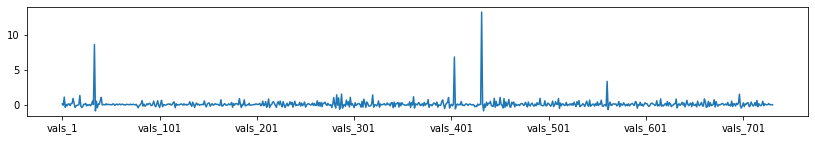

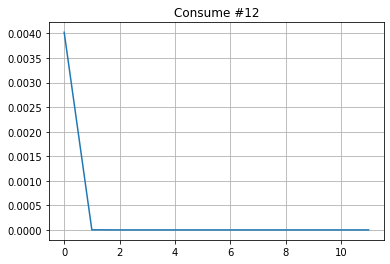

MIN и MAX ERR определения нормы: 0.0 	===> 0.0
MIN и MAX ERR определения аномалии: 0.0 	===> 0.0


In [22]:
#for i in firmNames:
for i in [1]:
  print('\n', '-'*30, '\n', firmNames[i])

  X_train, X_test, normal, frauds = get_consumer(dailyChange, i)
  print('frauds cases = ', len(frauds), '\tnormal cases = ', len(normal))
  print('X_train = ', X_train.shape, '\tX_test = ', X_test.shape, '\tfrauds = ', frauds.shape)

  Autoencoder(X_train)
  model_fit(X_train, firmNames, i)
  get_mistakes(X_test, frauds, firmNames, i)

### Проверяем каждое измерение

------------------------------ 
Для Consume # 12 :
 ------------------------------ 



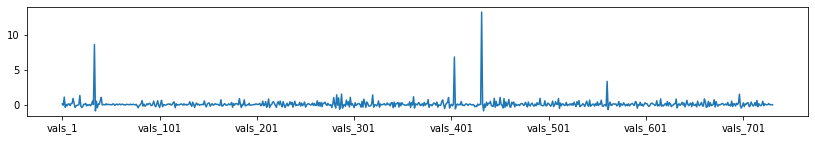

In [43]:
number = 1 # выбрали порядковый номер потребителя
consumer = dailyChange[firmNames[number]]
print('-'*30, '\nДля Consume #', firmNames[number], ':\n', '-'*30, '\n')
consumer.plot(figsize=(14, 2)) #строим график чтобы визуально оценить выбросы

In [44]:
consumer_stat = consumer.describe()
consumer_norma_min = consumer_stat['mean'] - 2*consumer_stat['std']
consumer_norma_max = consumer_stat['mean'] + 2*consumer_stat['std']
print("MIN и MAX определения нормы:", round(consumer_norma_min,4), '===>', round(consumer_norma_max,4))
normal = consumer[consumer <= consumer_norma_max] # Выделим норму меньше max
normal = normal[normal >= consumer_norma_min] # Выделим норму меньше max
print('Всего нормальных измерений:', normal.shape[0])

xScaler = MinMaxScaler()
xScaler.fit(normal.values.reshape(-1, 1))
consumer_normal_scal = xScaler.transform(normal.values.reshape(-1, 1))
consumer_scal = xScaler.transform(consumer.values.reshape(-1, 1))

#consumer_normal_scal = MinMaxScaler().fit_transform(normal.values.reshape(-1, 1)) # Нормализуем данные normal
model = Autoencoder(consumer_scal)
predictions_normal = model.predict(consumer_scal) # делаем предсказание по normal

# определяем среднеквадратичную ошибку по normal
consumer_norma_max = np.mean(predictions_normal) + 2*np.std(predictions_normal)
consumer_norma_min = np.mean(predictions_normal) - 2*np.std(predictions_normal)

# Определения нормы для скалированных данных
print("MIN и MAX определения нормы для нормализованных данных:", round(consumer_norma_min,4), '===>', round(consumer_norma_max,4))

MIN и MAX определения нормы: -1.3449 ===> 1.4927
Всего нормальных измерений: 726
MIN и MAX определения нормы для нормализованных данных: -0.0818 ===> 0.0145


In [45]:
# idx взят из математической проверки 
predictions = model.predict(consumer_scal)
n = 0
print('-'*30, '\nДни аномального потребления Consume #', firmNames[number], ':\n', '-'*30, '\n')
for i in range(len(consumer)):   # Выбираю пример
  if predictions[i] < consumer_norma_min or predictions[i] > consumer_norma_max:
    n += 1
    print(n, '\tДень', idx[i], '\tПотребление:', round(consumer[i], 4), '\t Отклонение')
  

------------------------------ 
Дни аномального потребления Consume # 12 :
 ------------------------------ 

1 	День vals_34 	Потребление: 8.5868 	 Отклонение
2 	День vals_288 	Потребление: 1.5014 	 Отклонение
3 	День vals_404 	Потребление: 6.7922 	 Отклонение
4 	День vals_432 	Потребление: 13.2073 	 Отклонение
5 	День vals_561 	Потребление: 3.3108 	 Отклонение


#2. Предсказать будущее значение потребления по конкретному потребителю
-----
В этой задаче 95-95% всех колебаний будут находиться внутри диапозона {Mean +/- 2*std}.

Поэтому задача имеет ценность, только если нужно научиться:
1. Делать предсказания сразу по нескольким тысячам потребителям, без написания некольких тысяч нейронок (но с сохранением их весов). Поставить их на поток..
2. Делать предсказания по Группам потребителей. Наверное, так даже правильнее, тк будут проявляться групповые особенности. Но только если потребители однродны внутри группы. Тут тоже 95-95% всех колебаний будут находиться внутри диапазона {Mean +/- 2*std)..



# 3. Что можно оставить в качестве домашних заданий:
* Доработать п1 так, чтобы в качестве ответа выдавалась сводная таблица с результатами, а не куча графиков, как сейчас
* Доработать п2 так, чтобы в качестве ответа выдавался dataframe где 0 = значение в диапозане normal, а 1 = frauds
* Провести эксперимент: можно ли написать нейронку, в которую загружается датасет с dailyChange как Х и размеченный датасет из п2 как Y. 

  Обучить ее так, чтобы добиться надежного выявления аномалий не при индивидуальном анализе, а сразу всего датасета. 

  Будет ли точнее результат, если делать такой анализ по группам? - пока вереятный ответ "У нас не получилось еще подобрать необходимую архитетуру сети с низкой ошибкой.. Но раз задача решается математически, то должна решаться и нейронкой".
  
  Как учебная задача или задача для соревнования такая задача вполне подойдет.